# <span style="color:blue">Projected Changes in the Hydrological Cycle Individual Notebook 
## <span style="color:blue"> Investigating Climate Change in Earth's Polar Regions
In this notebook, we will explore the question, __"Is it true that 'wet gets wetter, dry gets drier?"__ Using this question we can explore the hypothesis that areas with moisture increase their moisture content, and areas that are dry ow have low moisture content get even dryer as climate change increases. Data from the Coupled Model Intercomparison Project (CMIP6) can be analyzed to model future changes in the hydrologic cycle with the increase of CO2 emissions. 
    We will explore __SSP-585__, which is a "buisness as usual" scenario where projected carbon emissions follow a projected increase relative to our current output if we made no changes. We will also analyze __SSP-126__, which is a carbon emissions scenario where there is less concentration on economic growth and instead focuses on reducing emissions and creating a more sustainable society. 

 I will be looking at the datasets for:
- __Monthly sea surface salinity (sos)__
- __Monthly water vapor content (prw)__
- __Monthly evaporation rates (evspsbl)__
##### Author: Jaclyn Bihl 
##### Contact: tuq41877@temple.edu

## Datasets
The CMIP6 data stored in the Google Cloud Storage are derived from the original CMIP6 data files distributed via the Earth System Grid Federation (ESGF) (https://esgf-node.llnl.gov/projects/cmip6/).The CMIP6 hosted on Google Cloud are maintained by the Climate Data Science Lab at Lamont Doherty Earth Observatory (LDEO) of Columbia University, as part of the Pangeo Project.

In [10]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr  # to read in Zarr format
import gcsfs # to read google cloud data
import momlevel as ml
import cftime
import cmocean
import wocemaps
import cartopy.crs as ccrs


In [11]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6  

In [12]:
google_cloud_cmip6 = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')

In [13]:
# this only needs to be created once per Jupyter session
gcs = gcsfs.GCSFileSystem(token='anon')

### What is Salinity, Evaporation and Water Vapor?
Salinity: The amount of dissolved salts in water, measured in grams of salt per 1000 grams of water, defined as one practical salinity unit (PSU).

Evaporation: What occurs when a liquid turns into a gas It is measured in (kg/m²s), which is kilograms per meters squared per second.

Water Vapor: The amount of water vapor per unit area, measured in (kg per m²). 

How are we going to analyze this data? 
We will take the average of the first 20 years of data and the last 20 years of data to find the baseline conditions to compare our changes to. The, we will create a difference plot subtracting the first 20 years from the last and create a difference plot. 

## Sea Surface Salinity ssp126

In [15]:
sos_data = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Omon' & \
    variable_id == 'sos' & \
    experiment_id == 'ssp126' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr' & \
    member_id == 'r1i1p1f1'"
)

In [16]:
sos_zarr = sos_data.zstore.values[-1]

In [17]:
# create a mutable-mapping-style interface to the store
mapper_sos = gcs.get_mapper(sos_zarr)
# open the dataset using xarray and zarr
gfdl_esm4_sos_126 = xr.open_zarr(mapper_sos, 
                                consolidated=True,use_cftime=True).sos.rename({'lat':'latitude',
                                                             'lon':'longitude'})

In [18]:
sos_ssp585_data = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Omon' & \
    variable_id == 'sos' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr' & \
    member_id == 'r1i1p1f1'"
)
sos_585_zarr = sos_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_585_sos = gcs.get_mapper(sos_585_zarr)
# open the dataset using xarray and zarr
gfdl_esm4_585_sos = xr.open_zarr(mapper_585_sos, 
                                consolidated=True,use_cftime=True).sos.rename({'lat':'latitude',
                                                             'lon':'longitude'})

## Salinity Graphs

In [19]:
baseline_salinity_first_years = gfdl_esm4_sos_126.sel(time=slice('2015-01-16', '2035-01-01')).mean(dim='time')
baseline_salinity_last_years = gfdl_esm4_sos_126.sel(time=slice('2080-12-16', '2100-12-16')).mean(dim='time')

In [20]:
baseline_salinity_first_years_585 = gfdl_esm4_585_sos.sel(time=slice('2015-01-16', '2035-01-01')).mean(dim='time')
baseline_salinity_last_years_585 = gfdl_esm4_585_sos.sel(time=slice('2080-12-16', '2100-12-16')).mean(dim='time')
baseline_difference_585 = baseline_salinity_last_years_585 - baseline_salinity_first_years_585

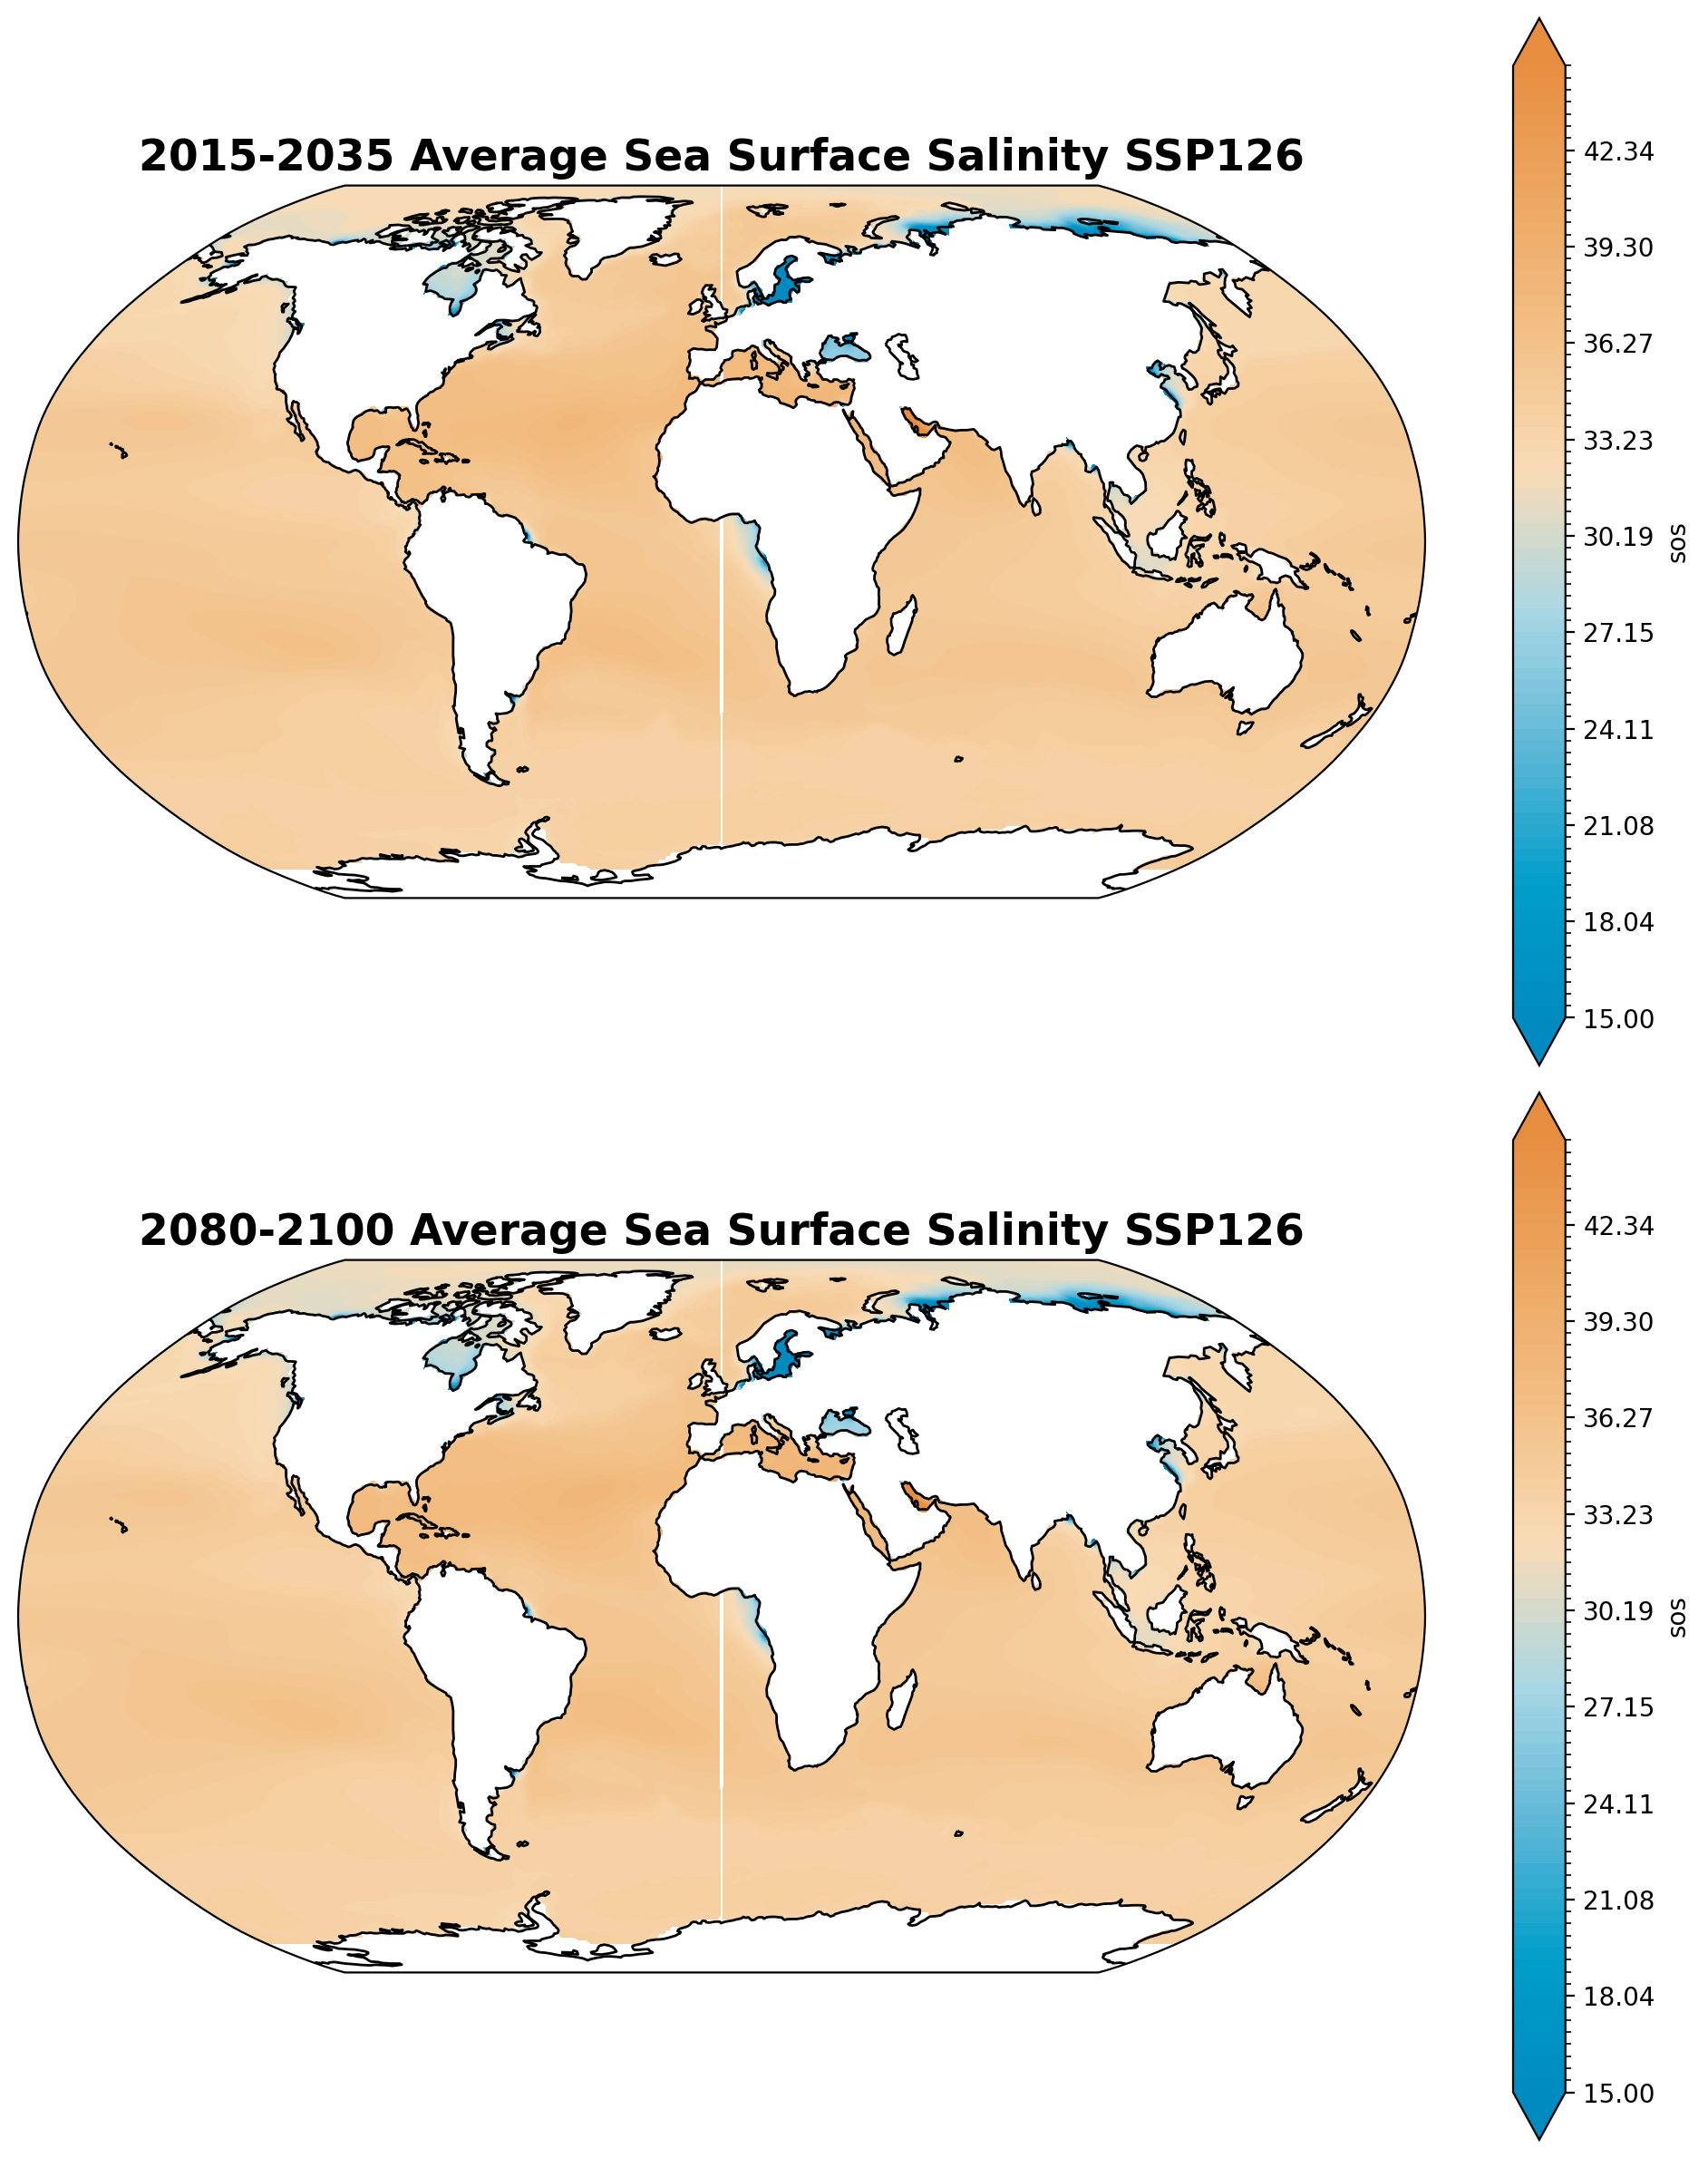

In [21]:
subplot_kws=dict(projection=ccrs.Robinson())

### set up our figure settings
fig, (ax1,ax2) = plt.subplots(ncols=1,
                               nrows=2,
                               figsize=(10,12),
                               subplot_kw=subplot_kws) ## set up our plotting area

### plot our data
baseline_salinity_first_years.plot.contourf(ax=ax1, cmap=wocemaps.salinity, levels=80, vmin=15, vmax=45, extend='both',
                                transform=ccrs.PlateCarree())
baseline_salinity_last_years.plot.contourf(ax=ax2, cmap=wocemaps.salinity, levels=80, vmin=15, vmax=45, extend='both',
                                transform=ccrs.PlateCarree())


## customize our subplots
ax1.set_title("2015-2035 Average Sea Surface Salinity SSP126", fontweight='bold', fontsize=17)
ax2.set_title('2080-2100 Average Sea Surface Salinity SSP126', fontweight='bold', fontsize=17)

ax1.set_ylabel('Latitude', fontsize = 15)
ax1.set_xlabel('Longitude', fontsize = 15)

ax2.set_ylabel('Latitude', fontsize = 15)
ax2.set_xlabel('Longitude', fontsize = 15)

plt.tight_layout() ## make it look nicely spaced!

### add some coastlines
ax1.coastlines()
ax2.coastlines()



__Figure 1.__ 2015-2035 Global Average Sea Surface Salinity from scenario SSP126 (top graph), 2080-2100 Global Average Sea Surface Salinity (bottom graph)

Sea surface salinity is directly affected by temperature and the overall water cycle of the earth. Salinity is generally a very stable value that does not fluctuate and change very much. Water tends to be fresher around the noth and south poles due to the melting of sea ice and evaporation. Changes in salinity can tell you how much precipitation the ocean got in a year or a specific area.

Major events in climate such and El Nino and La Nina can also affect erath's salinity. In the La nina years, places like Australia and the Philippines recieve more rainfall and the Indian Ocean recieves more freshwater than normal, reducing the salinity. Seawater desnity is also a factor to consider when talking about salinity. Salinity affects ocena circulation because saliter water is denser than freshwater, affecting the circulation of water and also how much heat is carried within these currents. 

In this scenario, emissions don't increase substantially, but level off and plateau from the current value. These graphs show how levels of salinity increase by a very minute amount. This is because global warming patterns increase evaporation and concentrates water in the North Atlantic because currents combined with trade winds carry moisture to the Pacific. 

In [22]:
baseline_difference = baseline_salinity_last_years - baseline_salinity_first_years

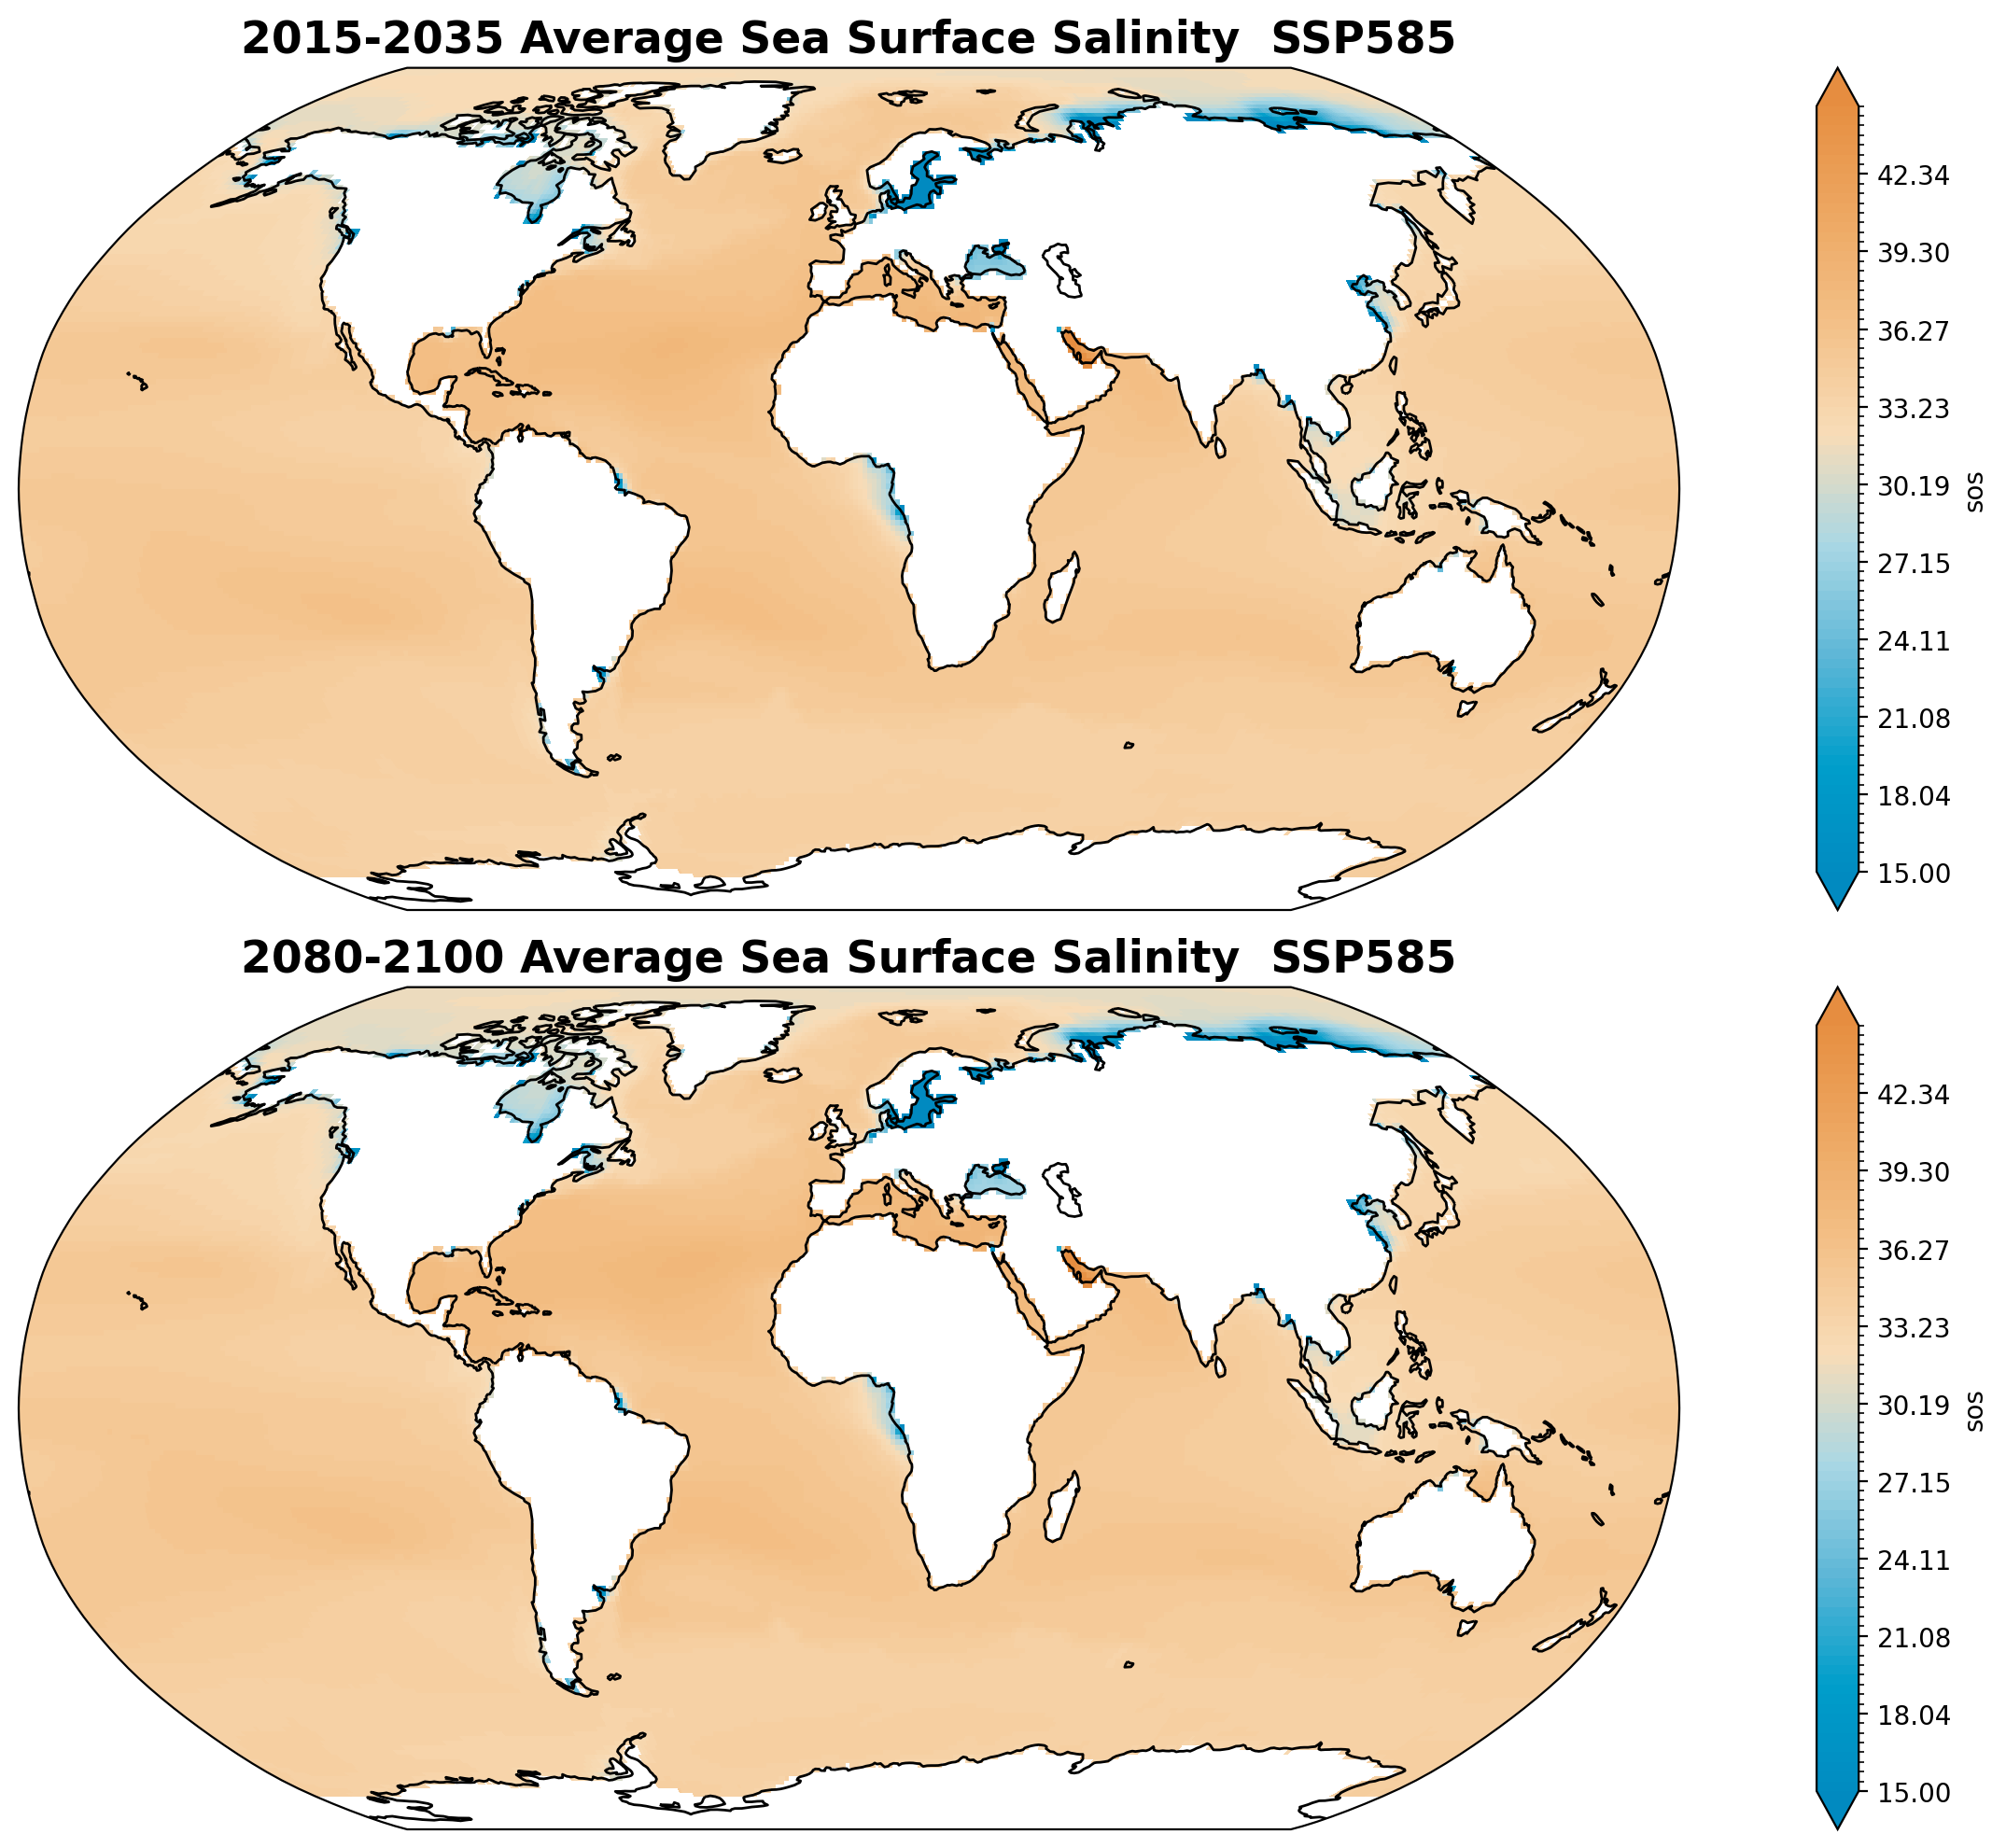

In [23]:
subplot_kws=dict(projection=ccrs.Robinson())

### set up our figure settings
fig, (ax1,ax2) = plt.subplots(ncols=1,
                               nrows=2,
                               figsize=(15,10),
                               subplot_kw=subplot_kws) ## set up our plotting area

### plot our data
baseline_salinity_first_years_585.plot(ax=ax1, cmap=wocemaps.salinity, extend='both', vmin=15, vmax=45,levels=80,
                                transform=ccrs.PlateCarree())
baseline_salinity_last_years_585.plot(ax=ax2, cmap=wocemaps.salinity, extend='both', vmin=15, vmax=45, levels=80,
                                transform=ccrs.PlateCarree())


## customize our subplots
ax1.set_title("2015-2035 Average Sea Surface Salinity  SSP585", fontweight='bold', fontsize=17)
ax2.set_title('2080-2100 Average Sea Surface Salinity  SSP585', fontweight='bold', fontsize=17)

plt.tight_layout() ## make it look nicely spaced!

### add some coastlines
ax1.coastlines()
ax2.coastlines()



__Figure 2.__ 2015-2035 Global Average Sea Surface Salinity from scenario SSP585 (top graph), 2080-2100 Global Average Sea Surface Salinity (bottom graph)

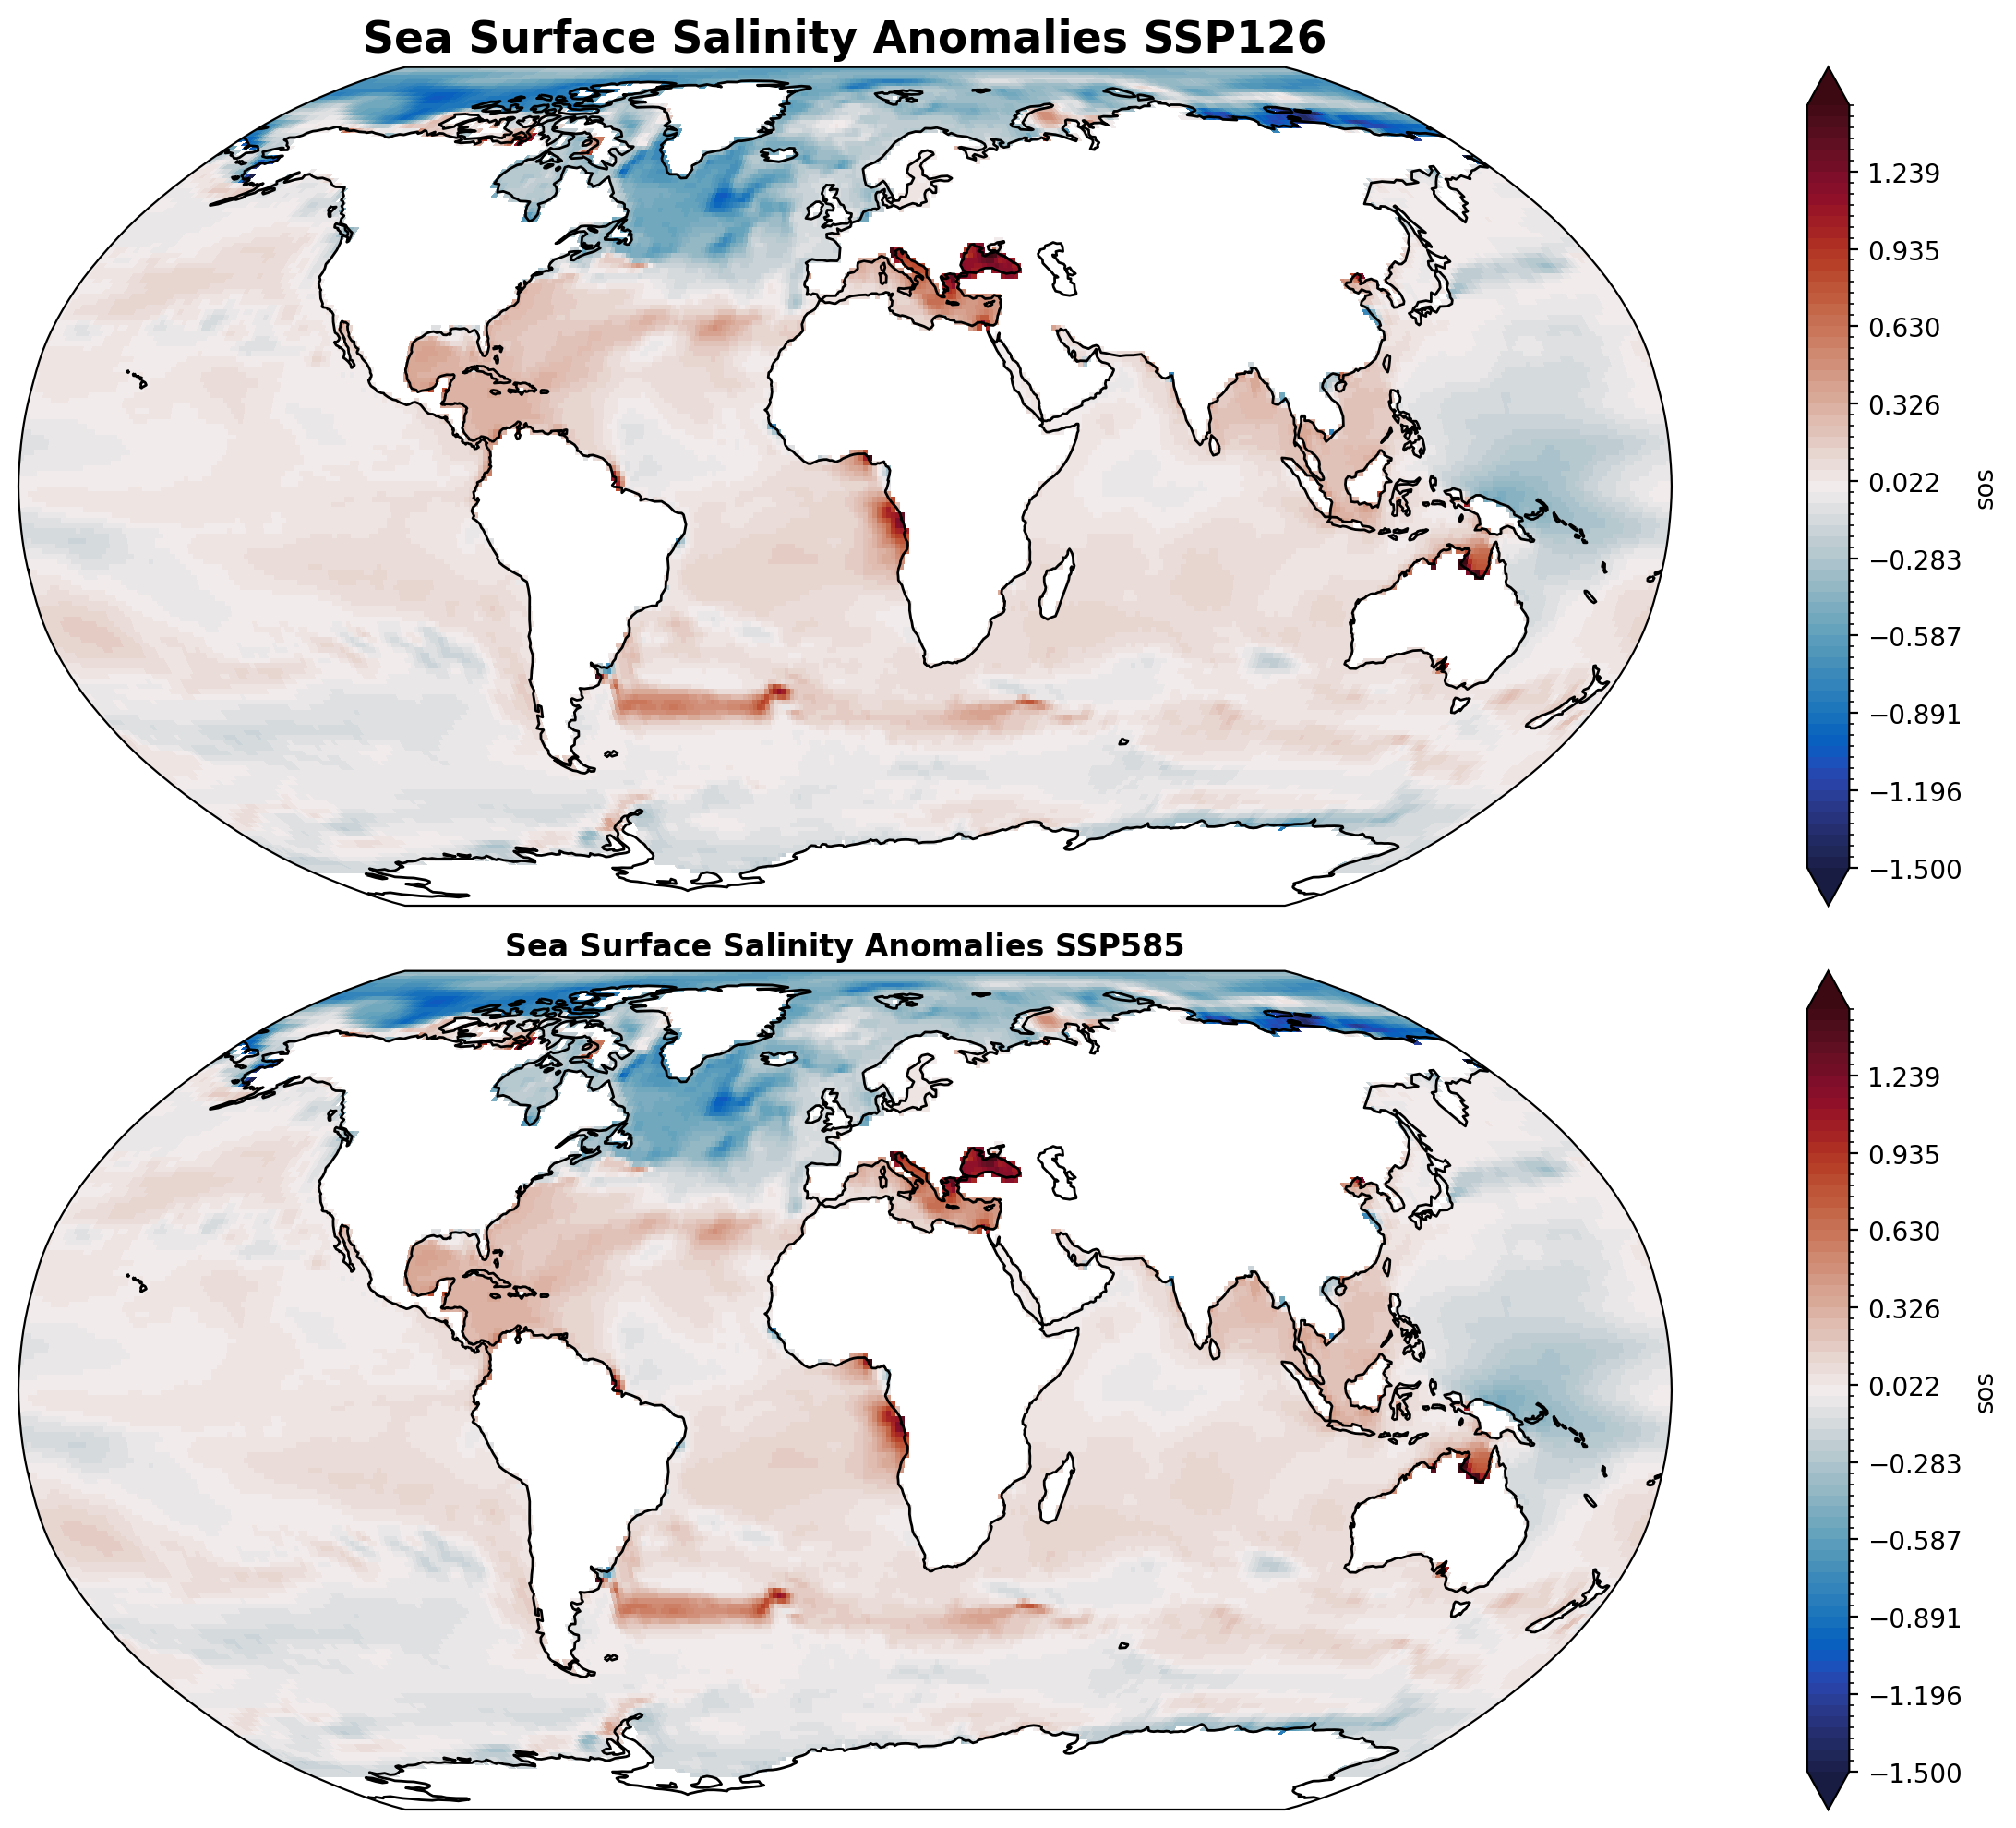

In [24]:
subplot_kws=dict(projection=ccrs.Robinson())

### set up our figure settings
fig, (ax1,ax2) = plt.subplots(ncols=1,
                               nrows=2,
                               figsize=(15,10),
                               subplot_kw=subplot_kws) ## set up our plotting area

### plot our data
baseline_difference.plot(ax=ax1, cmap = cmocean.cm.balance, extend='both', vmin=-1.5, vmax=1.5, levels=70,
                                transform=ccrs.PlateCarree())
baseline_difference_585.plot(ax=ax2, cmap = cmocean.cm.balance, extend='both', vmin=-1.5, vmax=1.5, levels=70,
                                transform=ccrs.PlateCarree())

## customize our subplots
ax1.set_title("Sea Surface Salinity Anomalies SSP126", fontweight='bold', fontsize=17)
ax2.set_title("Sea Surface Salinity Anomalies SSP585", fontweight='bold')

plt.tight_layout() ## make it look nicely spaced!

### add some coastlines
ax1.coastlines()
ax2.coastlines()




__Figure 3.__ Global Sea Surface Salinity Anomalies from scenario SSP585, relative to a baseline of data from 2015-2035.

Anomalies in climate data can give you information on how much the percent of your variable has changed from its' baseline values. In this case, The baseline differences from the first dataset from the beginning of the time period (2015-2035) are subtracted from the last 20 year period (2080-2100) to create a graph showing the change in salinity. The salinity levels increase around the equator and decrease around the poles, due to moisture being carried from subtropical zones and towards the poles, combined with trade winds to decrease the salinity in those areas. 
In terms of both climate scenarios, SSP126 and SSP585, there is not a noticable difference in the graphs for the anomallies. This is because on average, sea surface salinity only changes by less than one percent, which although can make a big difference even if it is not very noticable on the graph. However, this can help us to understand how salinity levels will follow ocean circulation and evaporation patterns that will carry more freshwater into northern latitiudes.

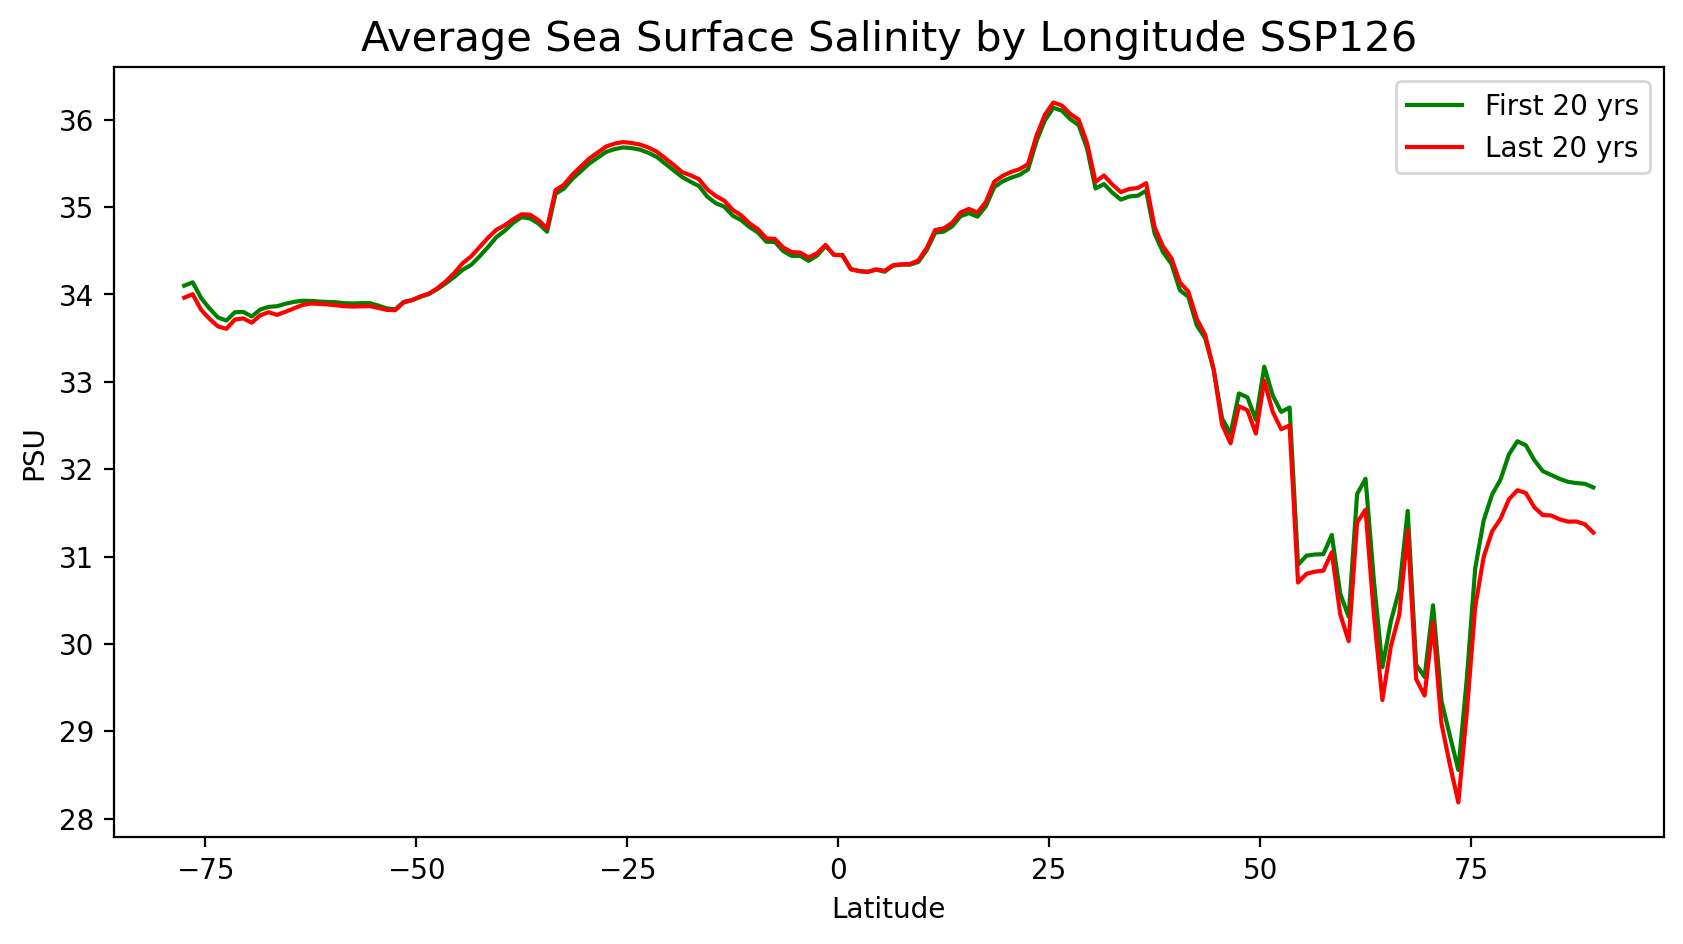

In [25]:
fig, ax = plt.subplots(figsize = (10,5))
avg_first_yearsos_126 = baseline_salinity_first_years.mean(dim = 'longitude').plot(color = 'green', label='First 20 yrs')
avg_last_yearsos_126 = baseline_salinity_last_years.mean(dim = 'longitude').plot(color = 'red', label='Last 20 yrs')
ax.set_title('Average Sea Surface Salinity by Longitude SSP126', fontsize = 15)
ax.set_xlabel('Latitude')
ax.set_ylabel("PSU")
ax.legend()

__Figure 4.__ Longitudinal Global Average Sea Surface Salinity from scenario SSP126

Increased carbon emissions coincide with decreased sea ice concentration in the north and south poles, and therefore pushing more freshwater into the ocean which can decrease the salinity. In scenario SSP126, it is clear that 
Since the south pole has less land mass and therefore more sea ice, it has a higher salinity due to the sea ice expelling salt into the water when it freezes. This could be the cause for higher salinity levels in the south pole and lower salinity in the north pole.

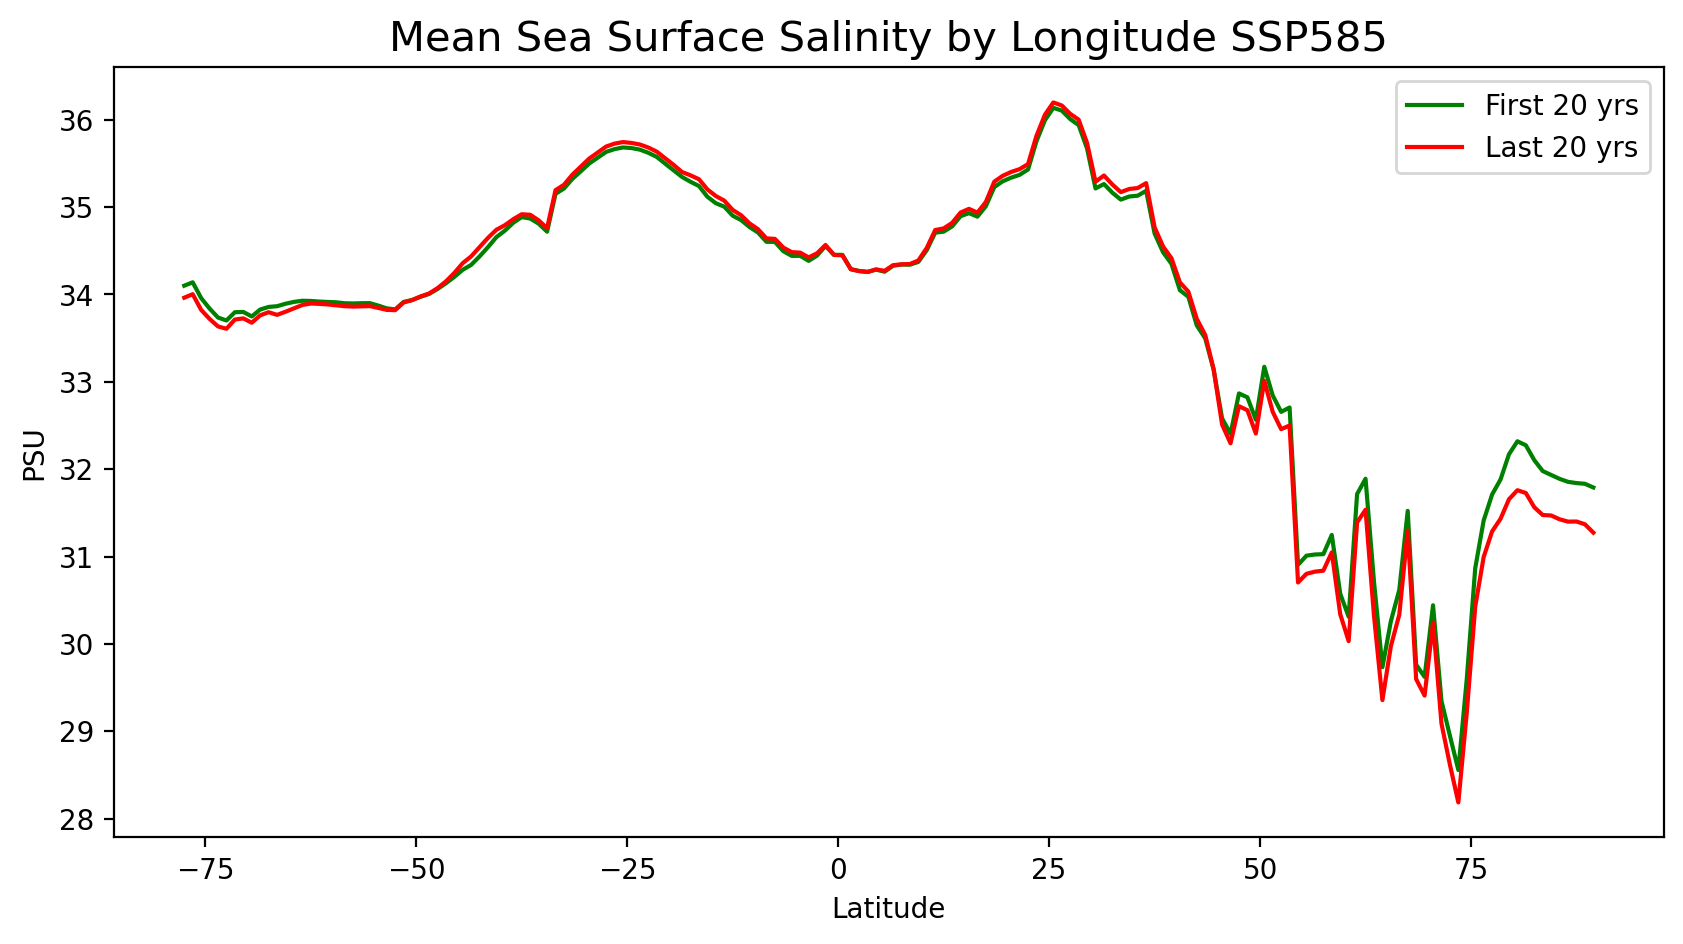

In [26]:
fig, ax = plt.subplots(figsize = (10,5))
avg_first_yearsos_585 = baseline_salinity_first_years_585.mean(dim = 'longitude').plot(color = 'green', label='First 20 yrs')
avg_last_yearsos_585 = baseline_salinity_last_years_585.mean(dim = 'longitude').plot(color = 'red', label='Last 20 yrs')
plt.title("Average Sea Surface Salinity by Latitude SSP585")
ax.set_title('Mean Sea Surface Salinity by Longitude SSP585', fontsize = 15)
ax.set_xlabel('Latitude')
ax.set_ylabel("PSU")
ax.legend()

__Figure 5.__ Mean Logitudinal Average Sea Surface Salinity from scenario SSP585

The differences of the two cross section graphs by longitude are very minute. With both scenarios following the same trends and having more freshwater in the north and saltier water in the south, There is not a lot of variation in the trends. At around 25N the salinity levels decrease and the water becomes fresher, following the same trends that I have discussed previously.

Climate change can amplify the earth's hydrologic cycle by increasing the amount of evaporation, precipitation that happens on earth. This significantly influences ocean's salinity. As water evaporates from the oceans, it leaves behind salts, increasing the salinity of the leftover water. This is more evident in warmer regions with high evaporation rates. Processes of the cycle, like precipitation runoff and evaporation lead to variations in salinity across the ocean.

# Monthly water vapor content 126

In [42]:
wv_ssp126_data = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Amon' & \
    variable_id == 'prw' & \
    experiment_id == 'ssp126' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr1' & \
    member_id == 'r1i1p1f1'"
)
wv_126_zarr = wv_ssp126_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_126_wv = gcs.get_mapper(wv_126_zarr)
# open the dataset using xarray and zarr
gfdl_esm4_126_wv = xr.open_zarr(mapper_126_wv, 
                                consolidated=True,use_cftime=True).prw.rename({'lat':'latitude',
                                                             'lon':'longitude'})

In [43]:
wv_first_years_126 = gfdl_esm4_126_wv.sel(time=slice('2015-01-16', '2035-01-01')).mean(dim='time')
wv_last_years_126 = gfdl_esm4_126_wv.sel(time=slice('2080-12-16', '2100-12-16')).mean(dim='time')
difference_wv_126 = wv_last_years_126 - wv_first_years_126

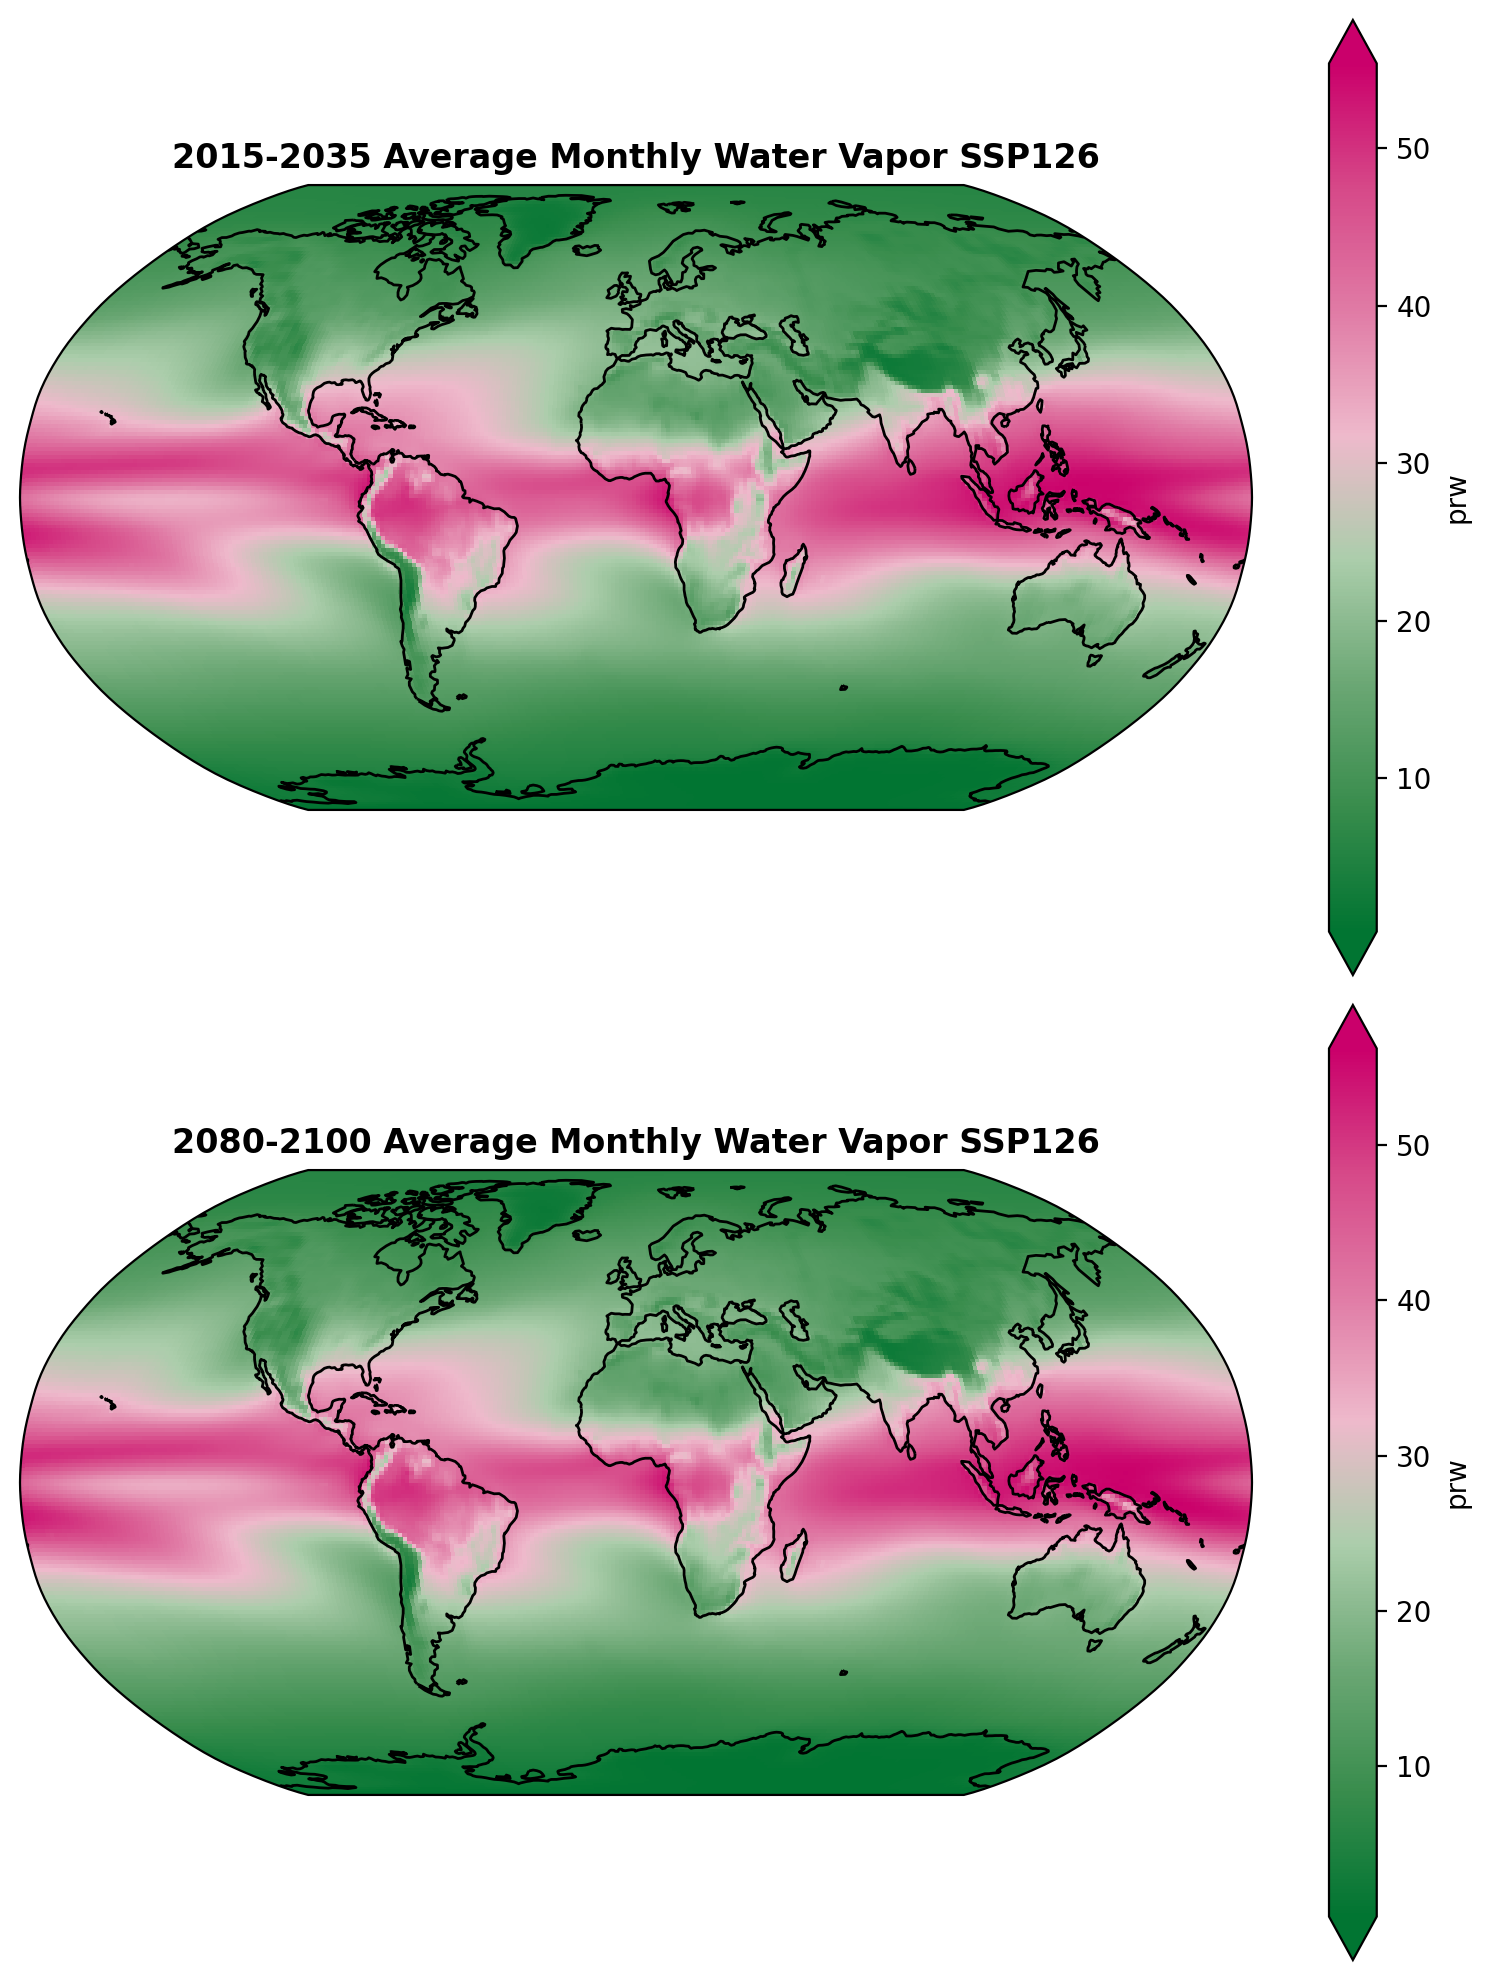

In [44]:
subplot_kws=dict(projection=ccrs.Robinson())

### set up our figure settings
fig, (ax1,ax2) = plt.subplots(ncols=1,
                               nrows=2,
                               figsize=(8,10),
                               subplot_kw=subplot_kws) ## set up our plotting area

### plot our data
wv_first_years_126.plot(ax=ax1, cmap=wocemaps.d14c, extend='both',
                                transform=ccrs.PlateCarree())
wv_last_years_126.plot(ax=ax2, cmap=wocemaps.d14c, extend='both',
                                transform=ccrs.PlateCarree())


## customize our subplots
ax1.set_title("2015-2035 Average Monthly Water Vapor SSP126", fontweight='bold')
ax2.set_title('2080-2100 Average Monthly Water Vapor SSP126', fontweight='bold')

ax1.set_ylabel('Latitude', fontsize = 15)
ax1.set_xlabel('Longitude', fontsize = 15)

ax2.set_ylabel('Latitude', fontsize = 15)
ax2.set_xlabel('Longitude', fontsize = 15)

plt.tight_layout() ## make it look nicely spaced!

### add some coastlines
ax1.coastlines()
ax2.coastlines()



__Figure 6.__ 2015-2035 monthly average water vapor content from scenario SSP126 (top graph), 2080-2100 monthly average water vapor content (bottom graph)

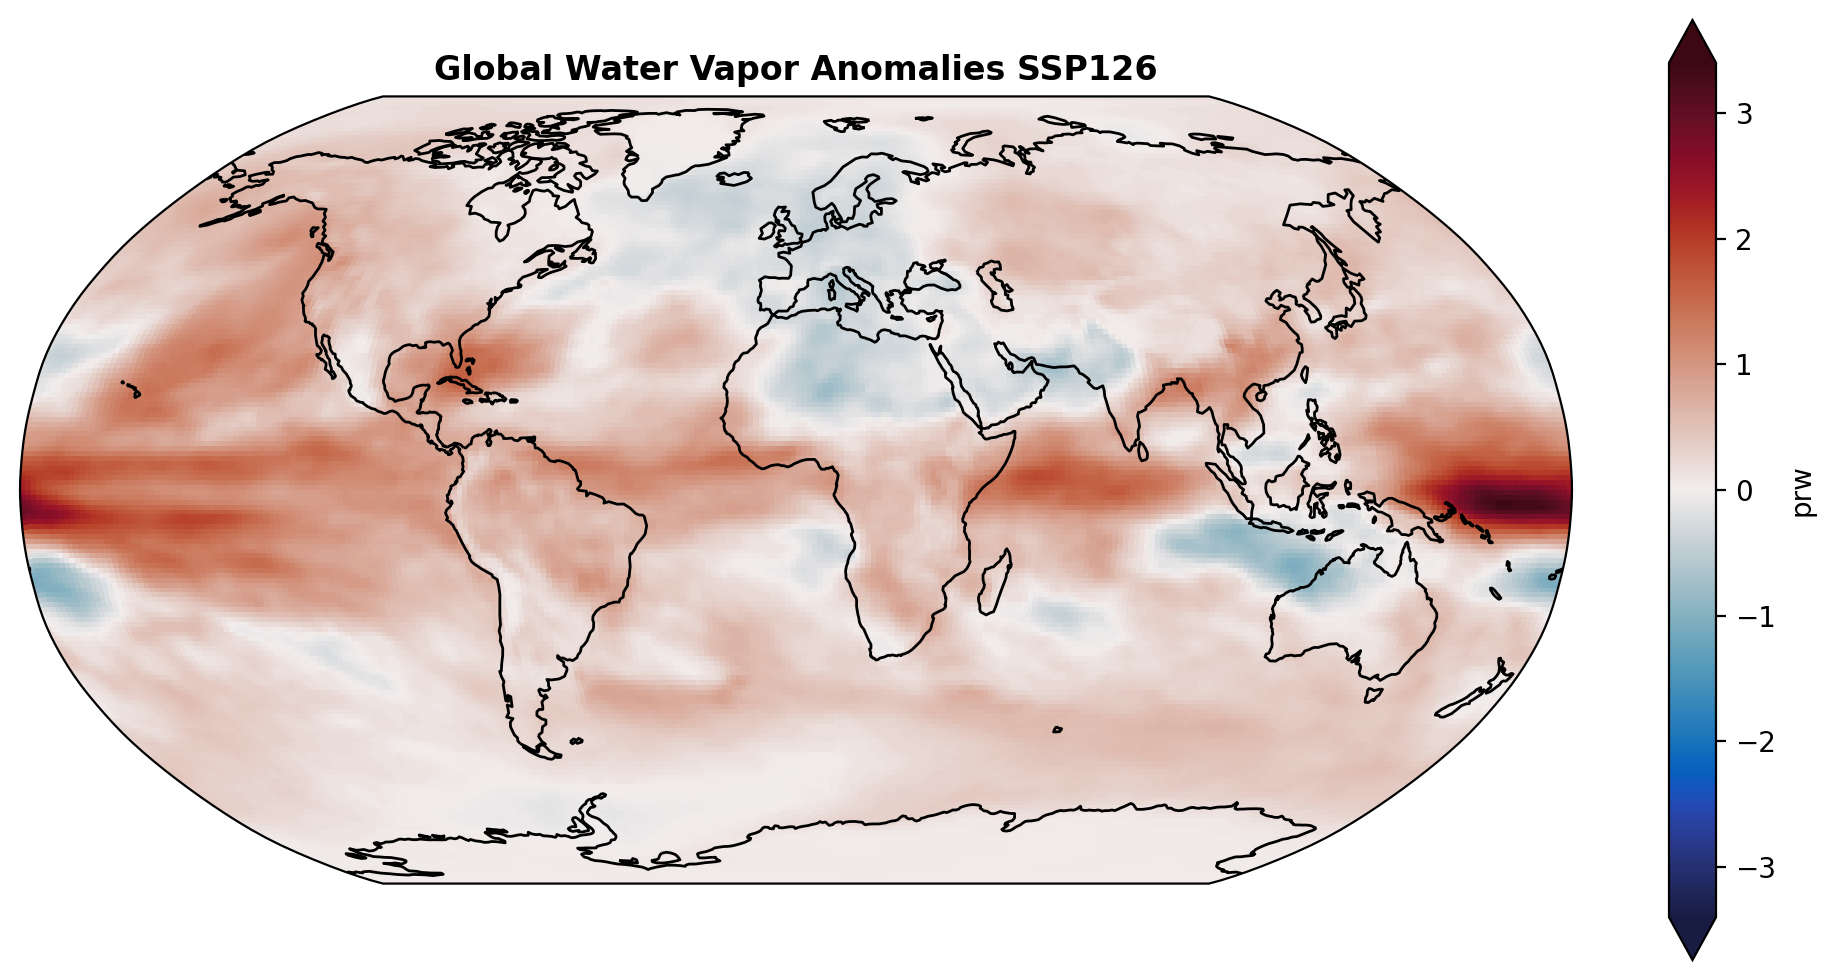

In [45]:
subplot_kws=dict(projection=ccrs.Robinson())

### set up our figure settings
fig, (ax1) = plt.subplots(ncols=1,
                               nrows=1,
                               figsize=(10,5),
                               subplot_kw=subplot_kws) ## set up our plotting area

### plot our data
difference_wv_126.plot(ax=ax1, cmap = cmocean.cm.balance, extend='both',
                                transform=ccrs.PlateCarree())

## customize our subplots
ax1.set_title("Global Water Vapor Anomalies SSP126", fontweight='bold')

ax1.set_ylabel('Latitude', fontsize = 15)
ax1.set_xlabel('Longitude', fontsize = 15)

plt.tight_layout() ## make it look nicely spaced!

### add some coastlines
ax1.coastlines()


__Figure 7.__ Global water vapor anomalies from scenario SSP126.

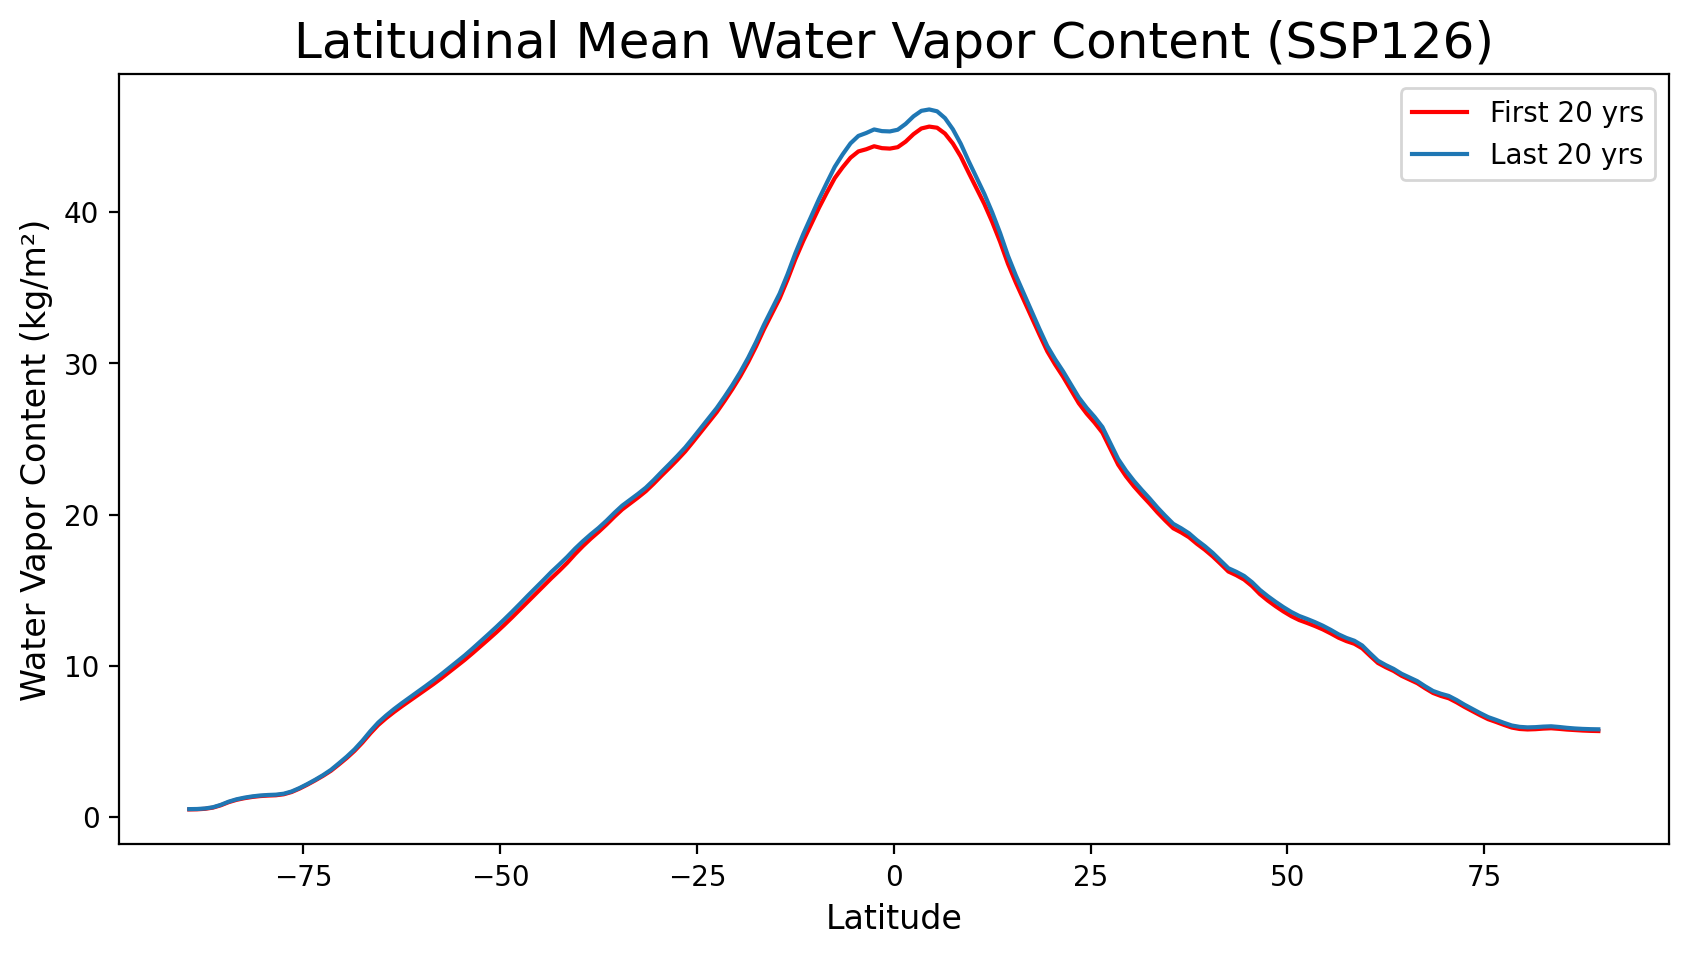

In [46]:
fig, ax = plt.subplots(figsize = (10,5))

av_wv_first_years_126 = wv_first_years_126.mean(dim='longitude').plot(color='red', label='First 20 yrs')
avg_wv_last_years_126 = wv_last_years_126.mean(dim='longitude').plot(label='Last 20 yrs')
ax.set_title('Latitudinal Mean Water Vapor Content (SSP126)', fontsize = 18)

# Adding axis titles/legends
ax.set_ylabel('Water Vapor Content (kg/m²)', fontsize = 12)
ax.set_xlabel('Latitude', fontsize = 12)
ax.legend()

__Figure 8.__ Logitudinally Averaged Water Vapor Content from scenario SSP126

In [47]:
# Code from Dr. Beadling:

# The following function is used to create weights for the Earths grid space.
import warnings 

def standard_grid_cell_area(latitude, longitude, rE=6371.0e3):
    """ computes the cell area for a standard spherical grid """

    dLat = latitude[1] - latitude[0]
    dLon = longitude[1] - longitude[0]
    area = np.empty((len(latitude), len(longitude)))
    for j in range(0, len(latitude)):
        for i in range(0, len(longitude)):
            lon1 = longitude[i] + dLon / 2
            lon0 = longitude[i] - dLon / 2
            lat1 = latitude[j] + dLat / 2
            lat0 = latitude[j] - dLat / 2
            area[j, i] = (
                (np.pi / 180.0)
                * rE
                * rE
                * np.abs(np.sin(np.radians(lat0)) - np.sin(np.radians(lat1)))
                * np.abs(lon0 - lon1)
            )
    return area

lat_sst = gfdl_esm4_126_wv.coords['latitude'].values #1-D numpy array of model's latitude values
lon_sst = gfdl_esm4_126_wv.coords['longitude'].values #1-D numpy array of model's longitude values

# make sure to replace the name of the data array if you chose a 
# different name and use the appropriate coordinate names within the ['']
# based on the coordinates of lat / lon in your dataset.

# Pass the arrays to the standard_grid_cell_area function
areacell = standard_grid_cell_area(lat_sst,lon_sst)  

# The areacella_xarray function outputs a numpy array. Convert this back into 
# and xarray DataArray for further use. If this is a field you will be using 
# often. You may wish to save this newly created DataArray as a Dataset and save 
# as a netcdf file.
# here we assign dimensions and coordinates that are the same as our original SST array:

areacell_xarray = xr.DataArray(areacell,dims=({'latitude':180, 'longitude':360}),\
                                                coords=(gfdl_esm4_126_wv.coords['latitude'],\
                                                        gfdl_esm4_126_wv.coords['longitude']))

In [48]:
weighted_prw126 = gfdl_esm4_126_wv.weighted(areacell_xarray).mean(['latitude', 'longitude']) 
weighted_prw585 = gfdl_esm4_585_wv.weighted(areacell_xarray).mean(['latitude', 'longitude'])

mean_prw126 = weighted_prw126.groupby('time.year').mean(dim = 'time')
mean_prw585 = weighted_prw585.groupby('time.year').mean(dim = 'time')

NameError: name 'gfdl_esm4_585_wv' is not defined

In [ ]:
# Establishing figure parameters
fig, ax = plt.subplots(figsize = (8, 10))

# Assigning each dataset to the appropriate axis
mean_prw126.plot(color = 'blue', label = 'SSP126')
mean_prw585.plot(color = 'red', label = 'SSP585')

# Adding figure titles
ax.set_title('Global Mean Weighted Water Vapor Content', fontsize = 18)

# Adding axis titles/legends
ax.set_ylabel('Water Vapor Content (kg/m²)', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)
ax.legend()

__Figure 9.__ Global mean weighted water vapor content from scenario SSP126.

## Evaporation including sublimination and transpiration

In [ ]:
evap_ssp126_data = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Amon' & \
    variable_id == 'evspsbl' & \
    experiment_id == 'ssp126' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr1' & \
    member_id == 'r1i1p1f1'"
)
evap_126_zarr = evap_ssp126_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_126_evap = gcs.get_mapper(evap_126_zarr)
# open the dataset using xarray and zarr
gfdl_esm4_126_evap = xr.open_zarr(mapper_126_evap, 
                                consolidated=True,use_cftime=True).evspsbl.rename({'lat':'latitude',
                                                             'lon':'longitude'})
gfdl_esm4_126_evap

## SSP126 Evaporation Graphs

In [ ]:
baseline_evap_first_years = gfdl_esm4_126_evap.sel(time=slice('2015-01-16', '2035-01-01')).mean(dim='time')
baseline_evap_last_years = gfdl_esm4_126_evap.sel(time=slice('2080-12-16', '2100-12-16')).mean(dim='time')
difference_evap_126 = baseline_evap_last_years - baseline_evap_first_years


In [ ]:
subplot_kws=dict(projection=ccrs.Robinson())

### set up our figure settings
fig, (ax1,ax2) = plt.subplots(ncols=1,
                               nrows=2,
                               figsize=(10,12),
                               subplot_kw=subplot_kws) ## set up our plotting area

### plot our data
baseline_evap_first_years.plot.contourf(ax=ax1, cmap=wocemaps.salinity,  levels=20, vmin=-0.00004, vmax=0.00008, extend='both',
                                transform=ccrs.PlateCarree())
baseline_evap_last_years.plot.contourf(ax=ax2, cmap=wocemaps.salinity, levels=20, vmin=-0.00004, vmax=0.00008, extend='both',
                                transform=ccrs.PlateCarree())


## customize our subplots
ax1.set_title("2015-2035 Average Evaporation  SSP126", fontweight='bold')
ax2.set_title('2080-2100 Average Evaporation  SSP126', fontweight='bold')

ax1.set_ylabel('Latitude', fontsize = 15)
ax1.set_xlabel('Longitude', fontsize = 15)

ax2.set_ylabel('Latitude', fontsize = 15)
ax2.set_xlabel('Longitude', fontsize = 15)

plt.tight_layout() ## make it look nicely spaced!

### add some coastlines
ax1.coastlines()
ax2.coastlines()



__Figure 10.__ 2015-2035 Average evaporation including transpiration and sublimination from scenario SSP126 (top graph), 2080-2100 Average Evaporation including transpiration and sublimination (bottom graph)

In [ ]:
subplot_kws=dict(projection=ccrs.Robinson())

### set up our figure settings
fig, (ax1, ax2) = plt.subplots(ncols=1,
                               nrows=2,
                               figsize=(10,5),
                               subplot_kw=subplot_kws) ## set up our plotting area

### plot our data
difference_evap_126.plot(ax=ax1, cmap = cmocean.cm.balance,extend='both',
                                transform=ccrs.PlateCarree())
difference_evap_585.plot(ax=ax2, cmap = cmocean.cm.balance,extend='both',
                                transform=ccrs.PlateCarree())

## customize our subplots
ax2.set_title("Global Evaporation Anomalies SSP585", fontweight='bold')
## customize our subplots
ax1.set_title("Global Evaporation Anomalies SSP126", fontweight='bold')

plt.tight_layout() ## make it look nicely spaced!
### add some coastlines
ax1.coastlines()
ax2.coastlines()



__Figure 11.__ Average evaporation including transpiration and sublimination anomalies from scenario SSP126 (top graph) and scenario SSP585(bottom graph).

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

avg_first_year_evap_126 = baseline_evap_last_years.mean(dim = 'longitude').plot(color = 'green', label='Last 20 yrs')
avg_last_year_evap_126 = baseline_evap_first_years.mean(dim = 'longitude').plot(color = 'red', label='First 20 yrs')
# Adding figure titles
ax.set_title('Mean Evaporation by Longitude SSP126', fontsize = 18)

# Adding axis titles/legends
ax.set_ylabel('Evaporation (kg/m²s)', fontsize = 12)
ax.set_xlabel('Latitude', fontsize = 12)
ax.legend()

__Figure 12.__ Average evaporation by Longitude from SSP126 from 2015-2100.

## Evaporation including sublimination and transpiration 585

In [ ]:
evap_ssp585_data = google_cloud_cmip6.query(
    "activity_id=='ScenarioMIP' & \
    table_id == 'Amon' & \
    variable_id == 'evspsbl' & \
    experiment_id == 'ssp585' & \
    institution_id == 'NOAA-GFDL' &  \
    source_id == 'GFDL-ESM4' & \
    grid_label == 'gr1' & \
    member_id == 'r1i1p1f1'"
)
evap_585_zarr = evap_ssp585_data.zstore.values[-1]
# create a mutable-mapping-style interface to the store
mapper_585_evap = gcs.get_mapper(evap_585_zarr)
# open the dataset using xarray and zarr
gfdl_esm4_585_evap = xr.open_zarr(mapper_585_evap, 
                                consolidated=True,use_cftime=True).evspsbl.rename({'lat':'latitude',
                                                             'lon':'longitude'})

## SSP585 Evaporation Graphs

In [ ]:
baseline_evap_first_years_585 = gfdl_esm4_585_evap.sel(time=slice('2015-01-16', '2035-01-01')).mean(dim='time')
baseline_evap_last_years_585 = gfdl_esm4_585_evap.sel(time=slice('2080-12-16', '2100-12-16')).mean(dim='time')

In [ ]:
subplot_kws=dict(projection=ccrs.Robinson())

### set up our figure settings
fig, (ax1,ax2) = plt.subplots(ncols=1,
                               nrows=2,
                               figsize=(10,12),
                               subplot_kw=subplot_kws) ## set up our plotting area

### plot our data
baseline_evap_first_years_585.plot.contourf(ax=ax1, cmap=wocemaps.salinity,  extend='both', vmin=0, vmax=0.00004, levels=60,
                                transform=ccrs.PlateCarree())
baseline_evap_last_years_585.plot.contourf(ax=ax2, cmap=wocemaps.salinity,extend='both', vmin=0, vmax=0.00004, levels=60, transform=ccrs.PlateCarree())


## customize our subplots
ax1.set_title("2015-2035 Average Evaporation SSP585", fontweight='bold')
ax2.set_title('2080-2100 Average Evaporation SSP585', fontweight='bold')

ax1.set_ylabel('Latitude', fontsize = 15)
ax1.set_xlabel('Longitude', fontsize = 15)

ax2.set_ylabel('Latitude', fontsize = 15)
ax2.set_xlabel('Longitude', fontsize = 15)

plt.tight_layout() ## make it look nicely spaced!

### add some coastlines
ax1.coastlines()
ax2.coastlines()



__Figure 13.__ 2015-2035 Average evaporation including transpiration and sublimination from scenario SSP585 (top graph), 2080-2100 Average Evaporation including transpiration and sublimination (bottom graph)

In [ ]:
difference_evap_585 = baseline_evap_last_years_585 - baseline_evap_first_years_585

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

avg_first_year_evap_585 = baseline_evap_last_years_585.mean(dim = 'longitude')
avg_last_year_evap_585 = baseline_evap_first_years_585.mean(dim = 'longitude')
avg_last_year_evap_585.plot(color='green', label='Last 20 yrs')
avg_first_year_evap_585.plot(color='red', label='First 20 yrs')

ax.set_title('Mean Evaporation by Latitude SSP585', fontsize = 18)

# Adding axis titles/legends
ax.set_ylabel('Evaporation (kg/m²s)', fontsize = 12)
ax.set_xlabel('Latitude', fontsize = 12)
ax.legend()

__Figure 14.__ Average evaporation by longitude from scenario SSP585

## Conclusion
In conclusion, salinity levels decreased in the northern hemisphere more than the southern hemisphere, and levels don't substantially increase in SSP12 or in SSP585. However, evaporation is consistent with salinity data because evaporation levels that are high around the equator have higher salt content, and levels that are lower around the northern and southern hemispheres have lower salinity levels. Water vapor content 